# **DenseNet**

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from dataloader import *
from densenet import densenet
from train import *

we prepared a sharelink from google dive:

https://drive.google.com/drive/folders/1aw7nqrXkBRZp94Ef04s3xeH-2gQRPb97?usp=sharing

Add a shortcut to your own google drive and mount drive on google colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##load data & model

In [3]:
#DIRECTORIES
path_metadata = "/content/drive/MyDrive/dataset/metadata.csv" ## directory of dataframe of image directories and classes
path_pneumonia = "/content/drive/MyDrive/dataset/Dataset/pneumonia" ## directory of images of pneumonia classes
directory_dataset='/content/drive/MyDrive/dataset/Dataset' ## directory of all classes folders

image_size=(224, 224)
batch_size = 32

## call a function to load datasets
train_dataset,validation_dataset,test_dataset, y_true,y_true_oh,train_steps,validation_steps,test_steps,_,_,_ = data_func(
    batch_size ,
    path_metadata ,
    path_pneumonia ,
    directory_dataset,
    image_size )

Found 2928 validated image filenames belonging to 3 classes.
Found 732 validated image filenames belonging to 3 classes.
Found 915 validated image filenames belonging to 3 classes.
Found 50 validated image filenames belonging to 3 classes.


In [4]:
input_shape = 224, 224, 3 # size and channel of images
n_classes = 3 # number of classes

# call the model
model = densenet(input_shape,n_classes)

##train

In [5]:
checkpoint_filepath =  '/content/dense'
opt = Adam(learning_rate = 0.001)

from time import time
start = time()

with tf.device('/gpu:0'):
  history_densnet,model1 = train(train_dataset, model,'densenet',
           train_steps,
           validation_dataset,
           validation_steps,
           checkpoint_filepath,
           epoch=150,
           opt = opt)

print('Total run time= {:.2f} min'.format((time()-start)/60))

Epoch 1/150
91/91 [==============================] - 1049s 11s/step - loss: 0.9607 - accuracy: 0.6378 - val_loss: 1.3969 - val_accuracy: 0.4006 - lr: 0.0010
Epoch 2/150
91/91 [==============================] - 83s 913ms/step - loss: 0.6296 - accuracy: 0.7476 - val_loss: 0.6982 - val_accuracy: 0.6974 - lr: 0.0010
Epoch 3/150
91/91 [==============================] - 81s 888ms/step - loss: 0.6144 - accuracy: 0.7617 - val_loss: 1.0243 - val_accuracy: 0.6151 - lr: 0.0010
Epoch 4/150
91/91 [==============================] - 82s 895ms/step - loss: 0.6362 - accuracy: 0.7483 - val_loss: 0.8560 - val_accuracy: 0.6037 - lr: 0.0010
Epoch 5/150
91/91 [==============================] - 85s 928ms/step - loss: 0.5573 - accuracy: 0.7800 - val_loss: 2.7939 - val_accuracy: 0.4716 - lr: 0.0010
Epoch 6/150
91/91 [==============================] - 87s 955ms/step - loss: 0.5317 - accuracy: 0.7880 - val_loss: 0.4657 - val_accuracy: 0.8097 - lr: 0.0010
Epoch 7/150
91/91 [==============================] - 81s 8

### model summary

In [6]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 224, 224, 3)  0           ['batch_normalization[0][0]']    
                                                                                              

## test evaluation

In [7]:
## evaluation with last epoch weights
loss, accuracy = model1.evaluate(test_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

915/915 [==============================] - 507s 553ms/step - loss: 0.3044 - accuracy: 0.8699
Loss:  0.30440619587898254
Accuracy:  0.8699453473091125


In [8]:
# loading the weights with the best accuracy of validation dataset
model1.load_weights(checkpoint_filepath)

In [9]:
loss, accuracy = model1.evaluate(test_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

915/915 [==============================] - 17s 19ms/step - loss: 0.1505 - accuracy: 0.9574
Loss:  0.1505066454410553
Accuracy:  0.9573770761489868


In [10]:
with tf.device('/gpu:0'):
  test_values = model1.predict(test_dataset, steps=test_steps)

915/915 [==============================] - 19s 18ms/step


In [11]:
#save the prediction of the model on the test dataset to use in ensemble model
np.save("test_p_dens", test_values)

### precision, recall, fscore

In [12]:
# preparing test result

test_value_max = np.argmax(test_values,axis=1)
test_value_max_oh = convert_to_one_hot(test_value_max,3).T

In [13]:
accuracy = accuracy_score(y_true_oh, test_value_max_oh)

print('Accuracy = {:.2f}%'.format(accuracy*100))
print(classification_report(y_true_oh, test_value_max_oh,target_names=['0','1','2']))

Accuracy = 95.74%
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       280
           1       0.98      0.99      0.99       320
           2       0.98      0.90      0.94       315

   micro avg       0.96      0.96      0.96       915
   macro avg       0.96      0.96      0.96       915
weighted avg       0.96      0.96      0.96       915
 samples avg       0.96      0.96      0.96       915



### confusion matrix

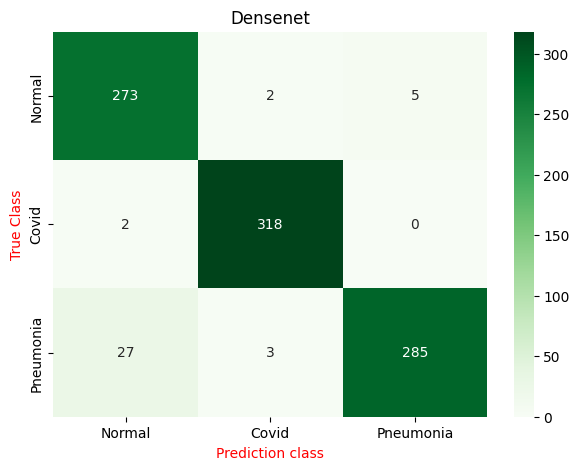

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(y_true,test_value_max)

plt.figure(figsize = (7,5))
plt.title('Densenet')
x_axis_labels = ['Normal','Covid','Pneumonia']
sns.heatmap(cf_matrix, annot=True,  fmt='g', cmap="Greens", xticklabels=x_axis_labels, yticklabels=x_axis_labels)
plt.xlabel('Prediction class', color = 'r')
plt.ylabel(ylabel='True Class', color="r")
plt.savefig('h_dense.png')